In [102]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import random

# Load exracted slot and tab data 
with open('slotFVsTrain.pkl', 'rb') as f:
    slotFVs = pickle.load(f)
with open('tabFVsTrain.pkl', 'rb') as f:
    tabFVs = pickle.load(f)

with open('pairIndices.pkl', 'rb') as f:
    pairIndices = pickle.load(f) # (slot index, tab index) of a positive pair


In [103]:
# # setup training feature vectors
# positive (match)
positive_examples = []
for i in range(len(pairIndices)):
    slotFV = slotFVs[pairIndices[i][0]][2] 
    tabFV = tabFVs[pairIndices[i][1]][2]

    fv = result = [a - b for a, b in zip(slotFV, tabFV)]
    # fv = np.concatenate([slotFV, tabFV])

    positive_examples.append(fv)
positive_examples = np.array(positive_examples)

# negative examples (mismatch)
negative_examples = []
for i in range(len(pairIndices)*20):
    slotFV = slotFVs[pairIndices[i%20][0]][2]
    tabIndex = random.randint(1, len(pairIndices)-1)
    while tabIndex == i:
        tabIndex = random.randint(1, len(pairIndices)-1)
    tabFV = tabFVs [pairIndices[tabIndex][0]][2]

    fv = result = [a - b for a, b in zip(slotFV, tabFV)]
    # fv = np.concatenate([slotFV, tabFV])

    negative_examples.append(fv)
negative_examples = np.array(negative_examples)

# Remove rows with infinity or NaN values - this is fine for training but for 
# testing, nothing should be removed - might need better puzzle or pictures
mask = ~(np.isinf(positive_examples) | np.isnan(positive_examples)).any(axis=1)
positive_examples = positive_examples[mask]

mask = ~(np.isinf(negative_examples) | np.isnan(negative_examples)).any(axis=1)
negative_examples = negative_examples[mask]

X = np.vstack([positive_examples, negative_examples])
y = np.array([1] * len(positive_examples) + [0] * len(negative_examples))


In [104]:
 # set up test feature vectors - same FVs for all models

import pickle
import numpy as np
# Load extracted test data
with open('slotFVsTest.pkl', 'rb') as f:
    slotFVs_test = pickle.load(f)
with open('tabFVsTest.pkl', 'rb') as f:
    tabFVs_test = pickle.load(f)

# Filter out border edges
filtered_slotFVs_test = []
filtered_tabFVs_test = []

for slot_fv in slotFVs_test:
    piece_id = slot_fv[0]
    edge_type = slot_fv[1]
    
    # Extract row and column from piece_id (format: "piece_XY" where X=row, Y=col)
    piece_num = piece_id.split('_')[1]
    row = int(piece_num[0])
    col = int(piece_num[1])
    
    # Filter out border edges
    if edge_type == 'left' and col == 1:
        continue
    if edge_type == 'right' and col == 5:
        continue
    if edge_type == 'top' and row == 1:
        continue
    if edge_type == 'bottom' and row == 5:
        continue
    
    filtered_slotFVs_test.append(slot_fv)

for tab_fv in tabFVs_test:
    piece_id = tab_fv[0]
    edge_type = tab_fv[1]
    
    # Extract row and column from piece_id
    piece_num = piece_id.split('_')[1]
    row = int(piece_num[0])
    col = int(piece_num[1])
    
    # Filter out border edges
    if edge_type == 'left' and col == 1:
        continue
    if edge_type == 'right' and col == 5:
        continue
    if edge_type == 'top' and row == 1:
        continue
    if edge_type == 'bottom' and row == 5:
        continue
    
    filtered_tabFVs_test.append(tab_fv)


# Create all combinations of slot and tab feature vectors - excluding border edges
#allCombos = [np.concatenate([slot_fv[2], tab_fv[2]]) for slot_fv in filtered_slotFVs_test for tab_fv in filtered_tabFVs_test]

allCombos = [np.array(slot_fv[2]) - np.array(tab_fv[2]) 
             for slot_fv in filtered_slotFVs_test 
             for tab_fv in filtered_tabFVs_test]

# Convert to numpy array for model prediction
allCombos = np.array(allCombos)

# matching algorithm accuracy - top 40
def is_correct_match(slot_id, slot_edge, tab_id, tab_edge):
    """Check if a predicted match is correct based on piece positions and edge orientations"""
    # Parse piece IDs to get row/col
    slot_num = slot_id.split('_')[1]
    slot_row, slot_col = int(slot_num[0]), int(slot_num[1])
    
    tab_num = tab_id.split('_')[1]
    tab_row, tab_col = int(tab_num[0]), int(tab_num[1])
    
    # for acuracy output - confirm results 
    if slot_edge == 'right' and tab_edge == 'left':
        return slot_row == tab_row and slot_col + 1 == tab_col
    elif slot_edge == 'left' and tab_edge == 'right':
        return slot_row == tab_row and slot_col - 1 == tab_col
    elif slot_edge == 'bottom' and tab_edge == 'top':
        return slot_row + 1 == tab_row and slot_col == tab_col
    elif slot_edge == 'top' and tab_edge == 'bottom':
        return slot_row - 1 == tab_row and slot_col == tab_col
    else:
        return False


In [105]:
# random forest training

# Combine data
X = np.vstack([positive_examples, negative_examples])
y = np.array([1] * len(positive_examples) + [0] * len(negative_examples))

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train
rf_model = RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_split=20, min_samples_leaf=10,   
    max_features='sqrt', random_state=42, class_weight='balanced')

rf_model.fit(X_train, y_train)



,n_estimators,200
,criterion,'gini'
,max_depth,8
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [106]:
# random forest testing

# Get match probabilities for ALL combinations
match_probs = rf_model.predict_proba(allCombos)[:, 1]

# Create list of all combinations with their probabilities
all_matches = []
for i, slot_fv in enumerate(filtered_slotFVs_test):
    for j, tab_fv in enumerate(filtered_tabFVs_test):
        combo_idx = i * len(filtered_tabFVs_test) + j
        all_matches.append({
            'slot_id': slot_fv[0],
            'slot_edge': slot_fv[1],
            'tab_id': tab_fv[0],
            'tab_edge': tab_fv[1],
            'probability': match_probs[combo_idx]
        })

# Sort all combinations by probability (highest first)
all_matches_sorted = sorted(all_matches, key=lambda x: x['probability'], reverse=True)

# Truncate list when all edges have been included at least once
seen_slots = set()
seen_tabs = set()
final_matches = []

for match in all_matches_sorted:
    slot_key = (match['slot_id'], match['slot_edge'])
    tab_key = (match['tab_id'], match['tab_edge'])
    
    final_matches.append(match)
    seen_slots.add(slot_key)
    seen_tabs.add(tab_key)
    
    # check if all edges have been seen
    if len(seen_slots) == len(filtered_slotFVs_test) and len(seen_tabs) == len(filtered_tabFVs_test):
        break

# print(f"\n=== Top {len(final_matches)} Matches (All edges covered) ===")
# for match in final_matches:
#     print(f"Slot {match['slot_id']} (edge: {match['slot_edge']}) -> Tab {match['tab_id']} (edge: {match['tab_edge']}) | prob: {match['probability']:.4f}")

with open('rf_predictions.pkl', 'wb') as f:
    pickle.dump(final_matches, f)

# Evaluate top 20
top_matches = all_matches_sorted[:40]
correct_count = 0

print("\nTop 40 Predictions")
for i, match in enumerate(top_matches, 1):
    is_correct = is_correct_match(match['slot_id'], match['slot_edge'], 
                                   match['tab_id'], match['tab_edge'])
    correct_count += is_correct
    status = "✓" if is_correct else "✗"
    print(f"{i:3d}. {status} Slot {match['slot_id']:8s} ({match['slot_edge']:6s}) AND Tab {match['tab_id']:8s} ({match['tab_edge']:6s}) | prob: {match['probability']:.6f}")

accuracy_top_matches = (correct_count / 40) * 100
print(f"\n=== Top 40 Accuracy: {accuracy_top_matches:.1f}% ({correct_count}/40 correct) ===")

probs = [m['probability'] for m in final_matches]



Top 40 Predictions
  1. ✓ Slot T0_51    (right ) AND Tab T0_52    (left  ) | prob: 0.969948
  2. ✓ Slot T0_32    (top   ) AND Tab T0_22    (bottom) | prob: 0.968245
  3. ✓ Slot T0_31    (right ) AND Tab T0_32    (left  ) | prob: 0.967284
  4. ✓ Slot T0_33    (bottom) AND Tab T0_43    (top   ) | prob: 0.966901
  5. ✓ Slot T0_41    (top   ) AND Tab T0_31    (bottom) | prob: 0.964608
  6. ✓ Slot T0_21    (right ) AND Tab T0_22    (left  ) | prob: 0.964205
  7. ✓ Slot T0_22    (top   ) AND Tab T0_12    (bottom) | prob: 0.964032
  8. ✓ Slot T0_54    (right ) AND Tab T0_55    (left  ) | prob: 0.963006
  9. ✓ Slot T0_53    (top   ) AND Tab T0_43    (bottom) | prob: 0.962824
 10. ✓ Slot T0_15    (left  ) AND Tab T0_14    (right ) | prob: 0.962752
 11. ✓ Slot T0_45    (top   ) AND Tab T0_35    (bottom) | prob: 0.962598
 12. ✓ Slot T0_11    (bottom) AND Tab T0_21    (top   ) | prob: 0.962100
 13. ✓ Slot T0_23    (right ) AND Tab T0_24    (left  ) | prob: 0.961263
 14. ✓ Slot T0_13    (bottom) A

[0]	validation_0-logloss:0.65205	validation_1-logloss:0.65191
[10]	validation_0-logloss:0.38318	validation_1-logloss:0.38366
[20]	validation_0-logloss:0.24311	validation_1-logloss:0.24467
[30]	validation_0-logloss:0.16182	validation_1-logloss:0.16430
[40]	validation_0-logloss:0.11502	validation_1-logloss:0.11812
[50]	validation_0-logloss:0.08695	validation_1-logloss:0.09077
[60]	validation_0-logloss:0.06957	validation_1-logloss:0.07411
[70]	validation_0-logloss:0.05845	validation_1-logloss:0.06351
[80]	validation_0-logloss:0.05063	validation_1-logloss:0.05618
[90]	validation_0-logloss:0.04475	validation_1-logloss:0.05081
[100]	validation_0-logloss:0.03983	validation_1-logloss:0.04649
[109]	validation_0-logloss:0.03665	validation_1-logloss:0.04394

most important features:
Feature 6: 0.0085
Feature 21: 0.0091
Feature 1: 0.0122
Feature 0: 0.0134
Feature 27: 0.0714
Feature 2: 0.0962
Feature 4: 0.0965
Feature 5: 0.1203
Feature 3: 0.1300
Feature 26: 0.3684


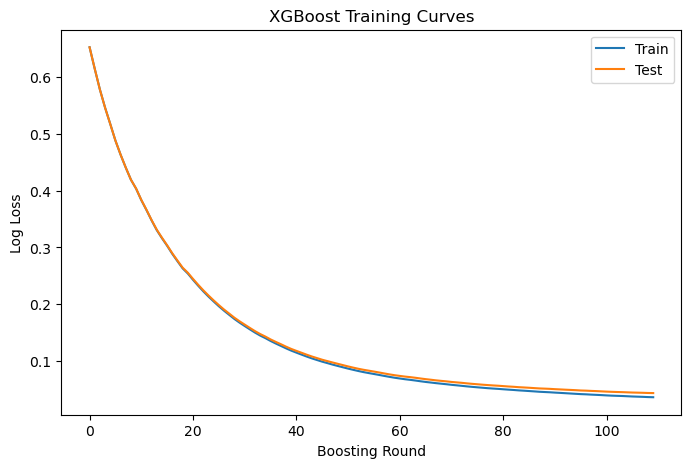

In [107]:
# XGBoost training
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# positive class scaling
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# train
xgb_model = xgb.XGBClassifier(
    n_estimators=110, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=scale_pos_weight,  
    min_child_weight=10, gamma=0.1, reg_alpha=0.1, reg_lambda=1.0, random_state=42, eval_metric='logloss')

# evaluation
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=10)

# Feature importance
importance = xgb_model.feature_importances_
print(f"\nmost important features:")
top_indices = np.argsort(importance)[-10:]
for idx in top_indices:
    print(f"Feature {idx}: {importance[idx]:.4f}")

# training curves 
results = xgb_model.evals_result()
plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['logloss'], label='Train')
plt.plot(results['validation_1']['logloss'], label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Training Curves')
plt.legend()
plt.show()


In [108]:
# XGBoost testing

# match probabilities for all combos
match_probs = xgb_model.predict_proba(allCombos)[:, 1]

all_matches = []
for i, slot_fv in enumerate(filtered_slotFVs_test):
    for j, tab_fv in enumerate(filtered_tabFVs_test):
        combo_idx = i * len(filtered_tabFVs_test) + j
        all_matches.append({'slot_id': slot_fv[0], 'slot_edge': slot_fv[1],'tab_id': tab_fv[0],'tab_edge': tab_fv[1],'probability': match_probs[combo_idx]})

# Sort all combinations by probability (highest first)
all_matches_sorted = sorted(all_matches, key=lambda x: x['probability'], reverse=True)

# Truncate list when all edges have been included
seen_slots = set()
seen_tabs = set()
final_matches = []

for match in all_matches_sorted:
    slot_key = (match['slot_id'], match['slot_edge'])
    tab_key = (match['tab_id'], match['tab_edge'])
    final_matches.append(match)
    seen_slots.add(slot_key)
    seen_tabs.add(tab_key)
    
    # check if all edges have been seen
    if len(seen_slots) == len(filtered_slotFVs_test) and len(seen_tabs) == len(filtered_tabFVs_test):
        break

# print(f"\nTop {len(final_matches)} Matches")
# for i, match in enumerate(final_matches, 1):
#     print(f"{i:3d}. Slot {match['slot_id']:8s} ({match['slot_edge']:6s}) -> Tab {match['tab_id']:8s} ({match['tab_edge']:6s}) | prob: {match['probability']:.6f}")

probs = [m['probability'] for m in final_matches]

with open('xgboost_predictions.pkl', 'wb') as f:
    pickle.dump(final_matches, f)
print("\nPredictions saved to 'xgboost_predictions.pkl'")

# Evaluate top 40
top_matches = all_matches_sorted[:40]
correct_count = 0

print("\nTop 40 matches")
for i, match in enumerate(top_matches, 1):
    is_correct = is_correct_match(match['slot_id'], match['slot_edge'], 
                                   match['tab_id'], match['tab_edge'])
    correct_count += is_correct
    status = "✓" if is_correct else "✗"
    print(f"{i:3d}. {status} Slot {match['slot_id']:8s} ({match['slot_edge']:6s}) AND Tab {match['tab_id']:8s} ({match['tab_edge']:6s}) | prob: {match['probability']:.6f}")

accuracy_top_matches = (correct_count / 40) * 100
print(f"\n Top 20 Accuracy: {accuracy_top_matches:.1f}% ({correct_count}/40 correct) ===")

probs = [m['probability'] for m in final_matches]

with open('xgboost_predictions.pkl', 'wb') as f:
    pickle.dump(final_matches, f)
print("\nPredictions saved to 'xgboost_predictions.pkl'")


Predictions saved to 'xgboost_predictions.pkl'

Top 40 matches
  1. ✓ Slot T0_13    (bottom) AND Tab T0_23    (top   ) | prob: 0.989029
  2. ✓ Slot T0_43    (right ) AND Tab T0_44    (left  ) | prob: 0.989029
  3. ✓ Slot T0_11    (bottom) AND Tab T0_21    (top   ) | prob: 0.988715
  4. ✓ Slot T0_21    (bottom) AND Tab T0_31    (top   ) | prob: 0.988715
  5. ✓ Slot T0_31    (right ) AND Tab T0_32    (left  ) | prob: 0.988715
  6. ✓ Slot T0_51    (right ) AND Tab T0_52    (left  ) | prob: 0.988715
  7. ✓ Slot T0_12    (right ) AND Tab T0_13    (left  ) | prob: 0.988715
  8. ✓ Slot T0_32    (bottom) AND Tab T0_42    (top   ) | prob: 0.988715
  9. ✓ Slot T0_52    (top   ) AND Tab T0_42    (bottom) | prob: 0.988715
 10. ✓ Slot T0_23    (right ) AND Tab T0_24    (left  ) | prob: 0.988715
 11. ✓ Slot T0_34    (bottom) AND Tab T0_44    (top   ) | prob: 0.988715
 12. ✓ Slot T0_32    (top   ) AND Tab T0_22    (bottom) | prob: 0.988389
 13. ✓ Slot T0_15    (left  ) AND Tab T0_14    (right ) | pr

In [109]:
# greedy reconstructor

import numpy as np
from collections import defaultdict

class PuzzleReconstructor:
    def __init__(self, final_matches, piece_data):
        self.matches = sorted(final_matches, key=lambda x: x['probability'], reverse=True)
        self.piece_data = piece_data
        self.grid = {}  # (row, col): piece_id
        self.placed_pieces = set()
        self.used_edges = set()
        
    def _get_opposite_position(self, position):
        opposites = {'top': 'bottom', 'bottom': 'top', 
                    'left': 'right', 'right': 'left'}
        return opposites[position]
    
    def _get_adjacent_cell(self, row, col, position):
        deltas = {'top': (-1, 0), 'bottom': (1, 0), 
                 'left': (0, -1), 'right': (0, 1)}
        dr, dc = deltas[position]
        return (row + dr, col + dc)
    
    def _can_place_piece(self, piece_id, row, col):
        if (row, col) in self.grid:
            return False
        if piece_id in self.placed_pieces:
            return False
        if piece_id not in self.piece_data:
            return False
        
        piece_edges = self.piece_data[piece_id]
        for position in ['top', 'right', 'bottom', 'left']:
            if position not in piece_edges:
                adj_row, adj_col = self._get_adjacent_cell(row, col, position)
                if (adj_row, adj_col) in self.grid:
                    return False
                continue
            
            edge_id = piece_edges[position]
            adj_row, adj_col = self._get_adjacent_cell(row, col, position)
            
            if (adj_row, adj_col) in self.grid:
                neighbor_piece = self.grid[(adj_row, adj_col)]
                
                if neighbor_piece not in self.piece_data:
                    continue
                
                opposite_pos = self._get_opposite_position(position)
                neighbor_edges = self.piece_data[neighbor_piece]
                
                if opposite_pos not in neighbor_edges:
                    return False
                    
                neighbor_edge = neighbor_edges[opposite_pos]
                
                is_valid_match = False
                for match in self.matches:
                    if ((match['slot_id'] == piece_id and match['slot_edge'] == edge_id and
                         match['tab_id'] == neighbor_piece and match['tab_edge'] == neighbor_edge) or
                        (match['tab_id'] == piece_id and match['tab_edge'] == edge_id and
                         match['slot_id'] == neighbor_piece and match['slot_edge'] == neighbor_edge)):
                        if match['probability'] > 0.5:
                            is_valid_match = True
                            break
                
                if not is_valid_match:
                    return False
        
        return True
    
    def _find_placement_for_match(self, slot_id, tab_id, slot_edge, tab_edge):
        slot_piece = slot_id
        tab_piece = tab_id
        
        if slot_piece in self.placed_pieces and tab_piece in self.placed_pieces:
            return None
        
        if slot_piece in self.placed_pieces:
            slot_positions = [pos for pos, p in self.grid.items() if p == slot_piece]
            if not slot_positions:
                return None
            slot_row, slot_col = slot_positions[0]
            
            tab_row, tab_col = self._get_adjacent_cell(slot_row, slot_col, slot_edge)
            
            if self._can_place_piece(tab_piece, tab_row, tab_col):
                return [(tab_row, tab_col, tab_piece)]
        
        elif tab_piece in self.placed_pieces:
            tab_positions = [pos for pos, p in self.grid.items() if p == tab_piece]
            if not tab_positions:
                return None
            tab_row, tab_col = tab_positions[0]
            
            slot_row, slot_col = self._get_adjacent_cell(tab_row, tab_col, tab_edge)
            
            if self._can_place_piece(slot_piece, slot_row, slot_col):
                return [(slot_row, slot_col, slot_piece)]
        
        else:
            if len(self.grid) > 0:
                return None
            
            slot_row, slot_col = 0, 0
            
            if slot_edge == 'right' and tab_edge == 'left':
                tab_row, tab_col = 0, 1
            elif slot_edge == 'left' and tab_edge == 'right':
                tab_row, tab_col = 0, -1
            elif slot_edge == 'bottom' and tab_edge == 'top':
                tab_row, tab_col = 1, 0
            elif slot_edge == 'top' and tab_edge == 'bottom':
                tab_row, tab_col = -1, 0
            else:
                tab_row, tab_col = 0, 1
            
            return [(slot_row, slot_col, slot_piece), (tab_row, tab_col, tab_piece)]
        
        return None
    
    def reconstruct(self):
        for match in self.matches:
            slot_id = match['slot_id']
            tab_id = match['tab_id']
            slot_edge = match['slot_edge']
            tab_edge = match['tab_edge']
            
            if slot_id not in self.piece_data or tab_id not in self.piece_data:
                continue
            
            if slot_id in self.placed_pieces and tab_id in self.placed_pieces:
                continue
            
            placement = self._find_placement_for_match(slot_id, tab_id, slot_edge, tab_edge)
            
            if placement:
                for row, col, piece_id in placement:
                    if piece_id not in self.placed_pieces:
                        self.grid[(row, col)] = piece_id
                        self.placed_pieces.add(piece_id)
                        self.used_edges.add((slot_id, slot_edge))
                        self.used_edges.add((tab_id, tab_edge))
            
            if len(self.placed_pieces) >= 25:
                break
        
        return self.grid
    
    def force_complete_reconstruction(self):
        unplaced = set(self.piece_data.keys()) - self.placed_pieces
        
        potential_positions = set()
        for (row, col) in self.grid.keys():
            for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                new_pos = (row + dr, col + dc)
                if new_pos not in self.grid:
                    potential_positions.add(new_pos)
        
        for piece_id in sorted(unplaced):
            best_position = None
            best_score = -1
            
            for pos in potential_positions:
                row, col = pos
                
                if self._can_place_piece_relaxed(piece_id, row, col):
                    score = self._calculate_placement_score(piece_id, row, col)
                    if score > best_score:
                        best_score = score
                        best_position = pos
            
            if best_position:
                row, col = best_position
                self.grid[(row, col)] = piece_id
                self.placed_pieces.add(piece_id)
                potential_positions.remove(best_position)
                
                for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                    new_pos = (row + dr, col + dc)
                    if new_pos not in self.grid:
                        potential_positions.add(new_pos)
    
    def _can_place_piece_relaxed(self, piece_id, row, col):
        if (row, col) in self.grid:
            return False
        if piece_id in self.placed_pieces:
            return False
        if piece_id not in self.piece_data:
            return False
        
        piece_edges = self.piece_data[piece_id]
        
        for position in ['top', 'right', 'bottom', 'left']:
            adj_row, adj_col = self._get_adjacent_cell(row, col, position)
            
            if position not in piece_edges:
                if (adj_row, adj_col) in self.grid:
                    return False
            else:
                if (adj_row, adj_col) in self.grid:
                    neighbor_piece = self.grid[(adj_row, adj_col)]
                    if neighbor_piece not in self.piece_data:
                        continue
                    
                    opposite_pos = self._get_opposite_position(position)
                    neighbor_edges = self.piece_data[neighbor_piece]
                    
                    if opposite_pos not in neighbor_edges:
                        return False
        return True
    
    def _calculate_placement_score(self, piece_id, row, col):
        score = 0
        piece_edges = self.piece_data[piece_id]
        
        for position in ['top', 'right', 'bottom', 'left']:
            if position not in piece_edges:
                continue
            
            edge_id = piece_edges[position]
            adj_row, adj_col = self._get_adjacent_cell(row, col, position)
            
            if (adj_row, adj_col) in self.grid:
                neighbor_piece = self.grid[(adj_row, adj_col)]
                opposite_pos = self._get_opposite_position(position)
                
                if neighbor_piece not in self.piece_data:
                    continue
                
                neighbor_edges = self.piece_data[neighbor_piece]
                if opposite_pos not in neighbor_edges:
                    continue
                
                neighbor_edge = neighbor_edges[opposite_pos]
                
                for match in self.matches:
                    if ((match['slot_id'] == piece_id and match['slot_edge'] == edge_id and
                         match['tab_id'] == neighbor_piece and match['tab_edge'] == neighbor_edge) or
                        (match['tab_id'] == piece_id and match['tab_edge'] == edge_id and
                         match['slot_id'] == neighbor_piece and match['slot_edge'] == neighbor_edge)):
                        score += match['probability']
                        break
        return score

def build_piece_data_from_fvs(slotFVs, tabFVs):
    piece_data = {}
    all_fvs = list(slotFVs) + list(tabFVs)
    
    for fv in all_fvs:
        piece_id = fv[0]
        edge_direction = fv[1]
        
        if piece_id not in piece_data:
            piece_data[piece_id] = {}
        
        piece_data[piece_id][edge_direction] = edge_direction
    
    return piece_data

# main
# with open('xgboost_predictions.pkl', 'rb') as f:
#     final_matches = pickle.load(f)

piece_data = build_piece_data_from_fvs(filtered_slotFVs_test, filtered_tabFVs_test)

reconstructor = PuzzleReconstructor(final_matches, piece_data)
grid = reconstructor.reconstruct()

if len(reconstructor.placed_pieces) < 25:
    reconstructor.force_complete_reconstruction()

Loaded 51 slot edges and 49 tab edges
Sample edge shape: (320, 95)
Saved malformed grid visualization to 'malformed_puzzle_5x5.png'


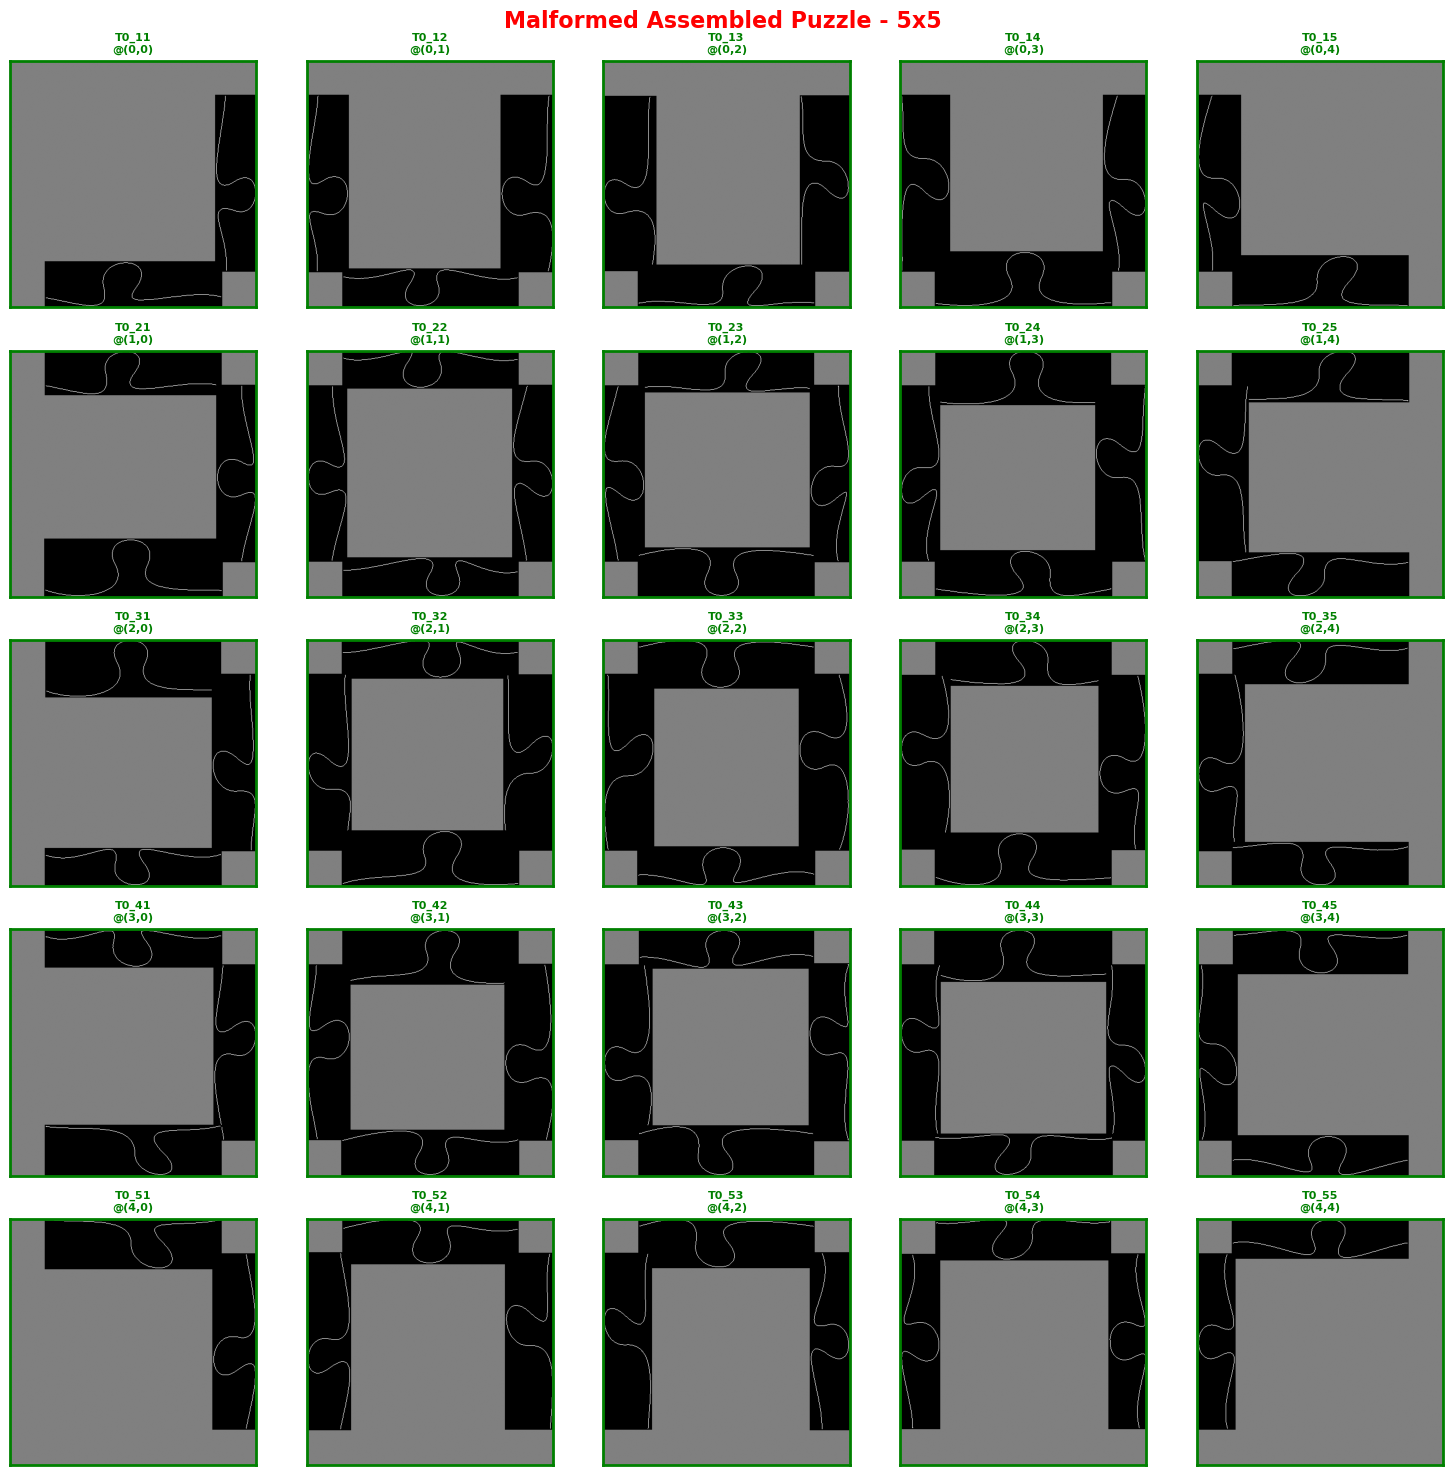

In [ ]:
# visualize with original edges

from matplotlib.patches import Rectangle

# load original edges
with open('allSlotsTest.pkl', 'rb') as f:
    all_slots = pickle.load(f)
with open('allTabsTest.pkl', 'rb') as f:
    all_tabs = pickle.load(f)

# Create a dictionary for fast lookup: (piece_id, edge_direction, edge_type) -> image
edge_images = {}

for item in all_slots:
    img, piece_id, edge_dir = item
    edge_images[(piece_id, edge_dir, 'slot')] = img

for item in all_tabs:
    img, piece_id, edge_dir = item
    edge_images[(piece_id, edge_dir, 'tab')] = img

print(f"Loaded {len(all_slots)} slot edges and {len(all_tabs)} tab edges")
if edge_images:
    sample_key = list(edge_images.keys())[0]
    sample_shape = edge_images[sample_key].shape
    print(f"Sample edge shape: {sample_shape}")

def rotate_edge_image(img, edge_direction, edge_type): # rotate original edge back to original orientation
    rotation_map = {
        ('right', 'slot'): 0,   # No rotation
        ('left', 'tab'): 0,     # No rotation
        ('top', 'tab'): -1,     # 90° CW
        ('top', 'slot'): 1,     # 90° CCW
        ('bottom', 'tab'): 1,   # 90° CCW
        ('bottom', 'slot'): -1, # 90° CW
        ('left', 'slot'): 2,    # 180°
        ('right', 'tab'): 2     # 180°
    }
    
    k = rotation_map.get((edge_direction, edge_type), 0)
    return np.rot90(img, k=k)

def get_edge_for_piece(piece_id, edge_direction, piece_data, final_matches):
    
    # Check if this edge exists for this piece
    if piece_id not in piece_data:
        return None
    if edge_direction not in piece_data[piece_id]:
        return None  # Border edge - no image
    
    # Find if this edge is a slot or tab by looking at matches
    edge_type = None
    for match in final_matches[:200]:  # Check top matches
        if match['slot_id'] == piece_id and match['slot_edge'] == edge_direction:
            edge_type = 'slot'
            break
        elif match['tab_id'] == piece_id and match['tab_edge'] == edge_direction:
            edge_type = 'tab'
            break
    
    if edge_type is None:
        # Edge not in top matches, try both
        if (piece_id, edge_direction, 'slot') in edge_images:
            edge_type = 'slot'
        elif (piece_id, edge_direction, 'tab') in edge_images:
            edge_type = 'tab'
        else:
            return None
    
    key = (piece_id, edge_direction, edge_type)
    if key not in edge_images:
        # Try alternate type
        alt_type = 'tab' if edge_type == 'slot' else 'slot'
        alt_key = (piece_id, edge_direction, alt_type)
        if alt_key in edge_images:
            key = alt_key
            edge_type = alt_type
        else:
            return None
    
    # Get the image and rotate it to the correct orientation
    img = edge_images[key]
    rotated = rotate_edge_image(img, edge_direction, edge_type)
    
    return rotated

def visualize_malformed_puzzle_grid(grid, piece_data, final_matches):
    if not grid:
        print("No grid to visualize!")
        return
    
    # Normalize grid to start at (0,0)
    rows = [pos[0] for pos in grid.keys()]
    cols = [pos[1] for pos in grid.keys()]
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)
    
    # Calculate ACTUAL assembled dimensions 
    actual_rows = max_row - min_row + 1
    actual_cols = max_col - min_col + 1
    
    # Create normalized grid
    normalized_grid = {}
    for (row, col), piece_id in grid.items():
        norm_row = row - min_row
        norm_col = col - min_col
        normalized_grid[(norm_row, norm_col)] = piece_id
    
    # Create figure with ACTUAL dimensions (not puzzle_size)
    fig, axes = plt.subplots(actual_rows, actual_cols, 
                             figsize=(3*actual_cols, 3*actual_rows))
    fig.suptitle(f'Malformed Assembled Puzzle - {actual_rows}x{actual_cols} ', 
                 fontsize=16, fontweight='bold', color='red')
    
    # Handle single row/col case
    if actual_rows == 1 and actual_cols == 1:
        axes = np.array([[axes]])
    elif actual_rows == 1:
        axes = axes.reshape(1, -1)
    elif actual_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Get sample edge dimensions
    sample_img = list(edge_images.values())[0]
    edge_h, edge_w = sample_img.shape
    
    # For each position in the ACTUAL grid
    for row in range(actual_rows):
        for col in range(actual_cols):
            ax = axes[row, col]
            
            if (row, col) not in normalized_grid:
                # Empty cell
                ax.text(0.5, 0.5, 'EMPTY', ha='center', va='center', 
                       fontsize=10, transform=ax.transAxes, color='red', 
                       fontweight='bold')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_facecolor('#ffcccc')
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(3)
                continue
            
            piece_id = normalized_grid[(row, col)]
            
            # Create a larger canvas to accommodate all possible edge sizes
            max_dim = max(edge_h, edge_w)
            canvas_h = round(max_dim * 1.4)
            canvas_w = round(max_dim * 1.4)
            canvas = np.ones((canvas_h, canvas_w)) * 0.5  # Gray background
            
            # Get and place each edge
            edges_to_place = []
            for edge_dir in ['top', 'left', 'right', 'bottom']:
                edge_img = get_edge_for_piece(piece_id, edge_dir, piece_data, final_matches)
                if edge_img is not None:
                    edges_to_place.append((edge_dir, edge_img))
            
            # Place edges with proper centering
            for edge_dir, edge_img in edges_to_place:
                eh, ew = edge_img.shape
                
                if edge_dir == 'top':
                    r = 0
                    c = (canvas_w - ew) // 2
                elif edge_dir == 'bottom':
                    r = canvas_h - eh
                    c = (canvas_w - ew) // 2
                elif edge_dir == 'left':
                    r = (canvas_h - eh) // 2
                    c = 0
                elif edge_dir == 'right':
                    r = (canvas_h - eh) // 2
                    c = canvas_w - ew
                
                # Ensure we don't go out of bounds
                r = max(0, r)
                c = max(0, c)
                r_end = min(r + eh, canvas_h)
                c_end = min(c + ew, canvas_w)
                
                # Place the edge
                canvas[r:r_end, c:c_end] = edge_img[:r_end-r, :c_end-c]
            
            # Display the piece
            ax.imshow(canvas, cmap='gray', vmin=0, vmax=1)
            
            # Color-code by correctness: check if piece is in correct position
            expected_row = int(piece_id.split('_')[1][0]) - 1
            expected_col = int(piece_id.split('_')[1][1]) - 1
            is_correct_position = (expected_row == row) and (expected_col == col)
            
            title_color = 'green' if is_correct_position else 'red'
            position_info = f"@({row},{col})"
            ax.set_title(f"{piece_id}\n{position_info}", 
                        fontsize=8, fontweight='bold', color=title_color)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add colored border
            border_color = 'green' if is_correct_position else 'orange'
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(2)
    
    plt.tight_layout()
    filename = f'malformed_puzzle_{actual_rows}x{actual_cols}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved malformed grid visualization to '{filename}'")
    plt.show()
    
visualize_malformed_puzzle_grid(grid, piece_data, final_matches)